[This](https://drzgan.github.io/Python_CFD/6.%20Burgers%27%20equation.html) online CFD in Python course has an example of solving Burgers' Equation using centered second order finite differences and backwards first order finite differences for spatial discretization and an explicit time step.

There is also an [example of Burger's Equation in 2D](https://drzgan.github.io/Python_CFD/11.%20Burgers%27%20equation.html).


From a different webpage, [here](https://www.thevisualroom.com/burgers_equation.html) is a good resource on 1-D with periodic boundary conditions, that also does a comparison to the analytical solution.

# 1D Burgers' Equation
---
Burgers' Equation is a combination of non-linear convection and diffusion.
\begin{split}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
\end{split}
It can be discretized as follows, using forward difference for time (an explicit time step), and a backwards finite difference and centered second order finite difference spatially. 
\begin{split}
\frac{u_i^{n+1}-u_i^n}{\Delta t} + u_i^n \frac{u_i^n - u_{i-1}^n}{\Delta x} = \nu \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\Delta x^2}
\end{split}
Note that due to the explicit time step, this is conditionally stable and the CFL number and diffusion limit number should be respected.

Additionally, note the usage of the backwards difference for the first order term. That, combined with the lack of a fully upwind scheme will cause issues with negative values. (At least I think thats the issue)

For boundary conditions, we can use either a periodic ($u(a, t) = u(b, t)$) or Direchlet ($u(x, t=0) = f(x)$) boundary condition.

Rearranging the discretized equation to isolate the solution at the next time step:
\begin{split}
u_i^{n+1} = u_i^n - \frac{u_i^n \Delta t}{\Delta x}\left(u_i^n - u_{i-1}^n \right) + \frac{\nu \Delta t}{\Delta x^2} \left(u_{i+1}^n - 2u_i^n + u_{i-1}^n\right)
\end{split}

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# set problem constants
NX = 71
XA = 0
XB = 1
LX = XB - XA
dX = LX / (NX - 1)  # spatial step size in X domain
nu = 0.001  # diffusion coefficient
gamma = 0.1  # linear advection coefficient
advection_scale = 0.6  # scaling the nonlinear advection
dt = 0.01
T = 3
NT = int(T / dt) + 1

tmesh = np.linspace(0, T, NT)

BOUNDARY_CONDITION = ["DIRECHLET", "PERIODIC"][0]

# check CFL number
CFL = dt / dX
print("CFL estimate is:", CFL)
if CFL > 1.0:
    print("WARNING: CFL IS LARGER THAN ONE")

# check stability number
CFL_diffusion = nu * dt / (dX**2)
print("Diffusion CFL is:", CFL_diffusion)
if CFL_diffusion > 0.5:
    print("WARNING: DIFFUSION CFL IS LARGER THAN 0.5")

CFL estimate is: 0.7000000000000001
Diffusion CFL is: 0.04900000000000001


In [3]:
x_domain = np.linspace(XA, XB, NX, endpoint=True)  # evaluation domain


In [6]:
BOUNDARY_CONDITION = ["DIRECHLET", "PERIODIC"][1]
ADVEC_MODE = ["LINEAR", "NONLINEAR"][1]

def solve_burgers_equation(u, ADVECTION:str="NONLINEAR", BOUNDARY:str="PERIODIC"):
    """Solves the 1D Burgers' Equation: du/dt + u(du/dx) = nu(d^2 u)/(dx^2).

    Args:
    - u: Solution grid with shape (NT, NX)
    - ADVECTION: "NONLINEAR" (default) or "LINEAR". Specifies convection mode.
    - BOUNDARY: "PERIODIC" (default) or "DIRECHLET". Specifies boundary condition.
    
    Returns:
    - u: solved solution grid
    """
    for tidx in range(NT - 1):
        match BOUNDARY:
            case "DIRECHLET":
                u[tidx + 1, 0] = u[tidx, 0]
                u[tidx + 1, -1] = u[tidx, -1]
                LXB = 1
                RXB = NX - 1
            case "PERIODIC":
                LXB = 0
                RXB = NX
            case _:
                pass
        for xidx in range(LXB, RXB):
            xidx_R = xidx + 1
            xidx_L = xidx - 1
            match BOUNDARY:
                case "DIRECHLET":
                    pass
                case "PERIODIC":
                    if xidx == 0:
                        xidx_L = NX - 1
                    elif xidx == NX - 1:
                        xidx_R = 0
                case _:
                    pass
            advec_L = (u[tidx, xidx] - u[tidx, xidx_L]) * advection_scale
            advec_R = (u[tidx, xidx_R] - u[tidx, xidx]) * advection_scale
            u[tidx + 1, xidx] = (
                u[tidx, xidx] 
                - u[tidx, xidx] * (dt / dX) * (advec_L) * int(u[tidx, xidx] >= 0) * int(ADVECTION=="NONLINEAR")  # non-linear advection, right side
                - u[tidx, xidx] * (dt / dX) * (advec_R) * int(u[tidx, xidx] < 0) * int(ADVECTION=="NONLINEAR")  # non-linear advection, left side
                - gamma * (dt / dX) * (u[tidx, xidx] - u[tidx, xidx_L]) * int(ADVECTION=="LINEAR")  # linear advection
                + (nu * dt / (dX**2)) * (u[tidx, xidx_R] - 2 * u[tidx, xidx] + u[tidx, xidx_L])  # diffusion term
            )
    return u

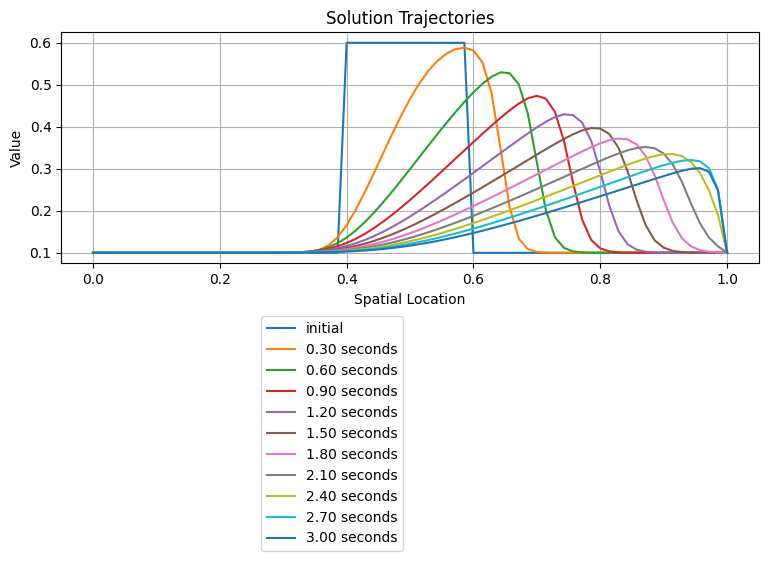

In [7]:
u = np.zeros((NT, NX)) + 0.1
#u[0, int(0.3*NX):int(0.4*NX)] = -0.1
u[0, int(0.4*NX):int(0.6*NX)] += 0.5
#u[0, :] = f_hanned + 0.5

def plot_trajectories(u, dt:float=0.01, mesh=None, t_interval:float=1.0, figuresize=(9,3)):
    plt.figure(figsize=figuresize)
    if mesh is None:
        plt.plot(u[0, :], label="initial")
    else:
        plt.plot(mesh, u[0, :], label="initial")
    walk = int(t_interval/dt)
    idx = walk
    while idx < u.shape[0]:
        if mesh is None:
            plt.plot(u[idx, :], label=f"{idx * dt:.2f} seconds")
        else:
            plt.plot(mesh, u[idx, :], label=f"{idx * dt:.2f} seconds")
        idx += walk
    plt.title(f"Solution Trajectories")
    plt.xlabel("Spatial Location")
    plt.ylabel("Value")
    plt.grid()
    plt.legend(bbox_to_anchor=(0.5, -0.2))

u = solve_burgers_equation(u, ADVECTION="NONLINEAR", BOUNDARY="DIRECHLET")

plot_trajectories(u, dt=dt, mesh = x_domain, t_interval=0.3)

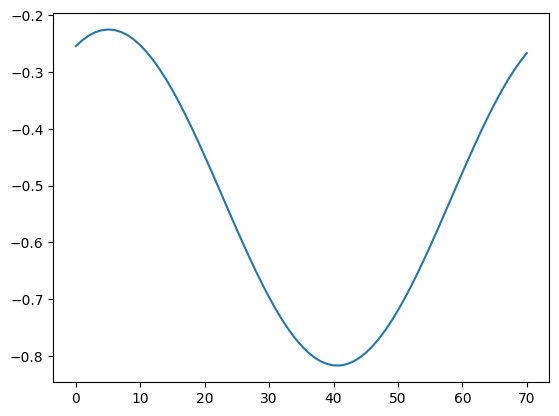

In [111]:
def chebyshev_initial_condition():
    c = np.random.rand(3) - 0.3
    f = np.polynomial.chebyshev.chebval(x_domain, c)  # evaluate polynomial
    # f_hanned = f * np.sin(x_domain * np.pi) 
    # f_hanned /= np.max(np.abs(f))*2  # apply a "Hanning window" to allow for periodic boundary conditions and scale
    f_diff = f - f[0]
    f_blended = f - np.maximum(np.zeros_like(f), np.sign(x_domain - 0.5) * (x_domain - 0.5)**2 * (1 / (1 - 0.5)**2)) * f_diff
    return f_blended

def periodic_initial_condition(n_points=NX, n_modes=1):
    x = np.linspace(0, 1, n_points, endpoint=False)
    u0 = np.random.normal(0, 1)  # random mean (k=0 mode)
    
    for k in range(1, n_modes + 1):
        a_k = np.random.normal(0, 1/k)
        b_k = np.random.normal(0, 1/k)
        u0 += a_k * np.cos(2*np.pi*k*x) + b_k * np.sin(2*np.pi*k*x)
    
    return u0 / 4

trace = periodic_initial_condition()
# print(trace)
plt.plot(trace)

In [110]:
# Time to generate training data!

samples = []
for sdx in range(180):
    u0 = periodic_initial_condition()
    u = np.zeros((NT, NX))
    # u[0, int(0.3*NX):int(0.4*NX)] = -0.1
    # u[0, int(0.4*NX):int(0.6*NX)] = 0.1
    # u[0, :] = f_hanned + 0.5
    u[0, :] = u0
    u = solve_burgers_equation(u)
    samples.append(u)
samples = np.stack(samples)

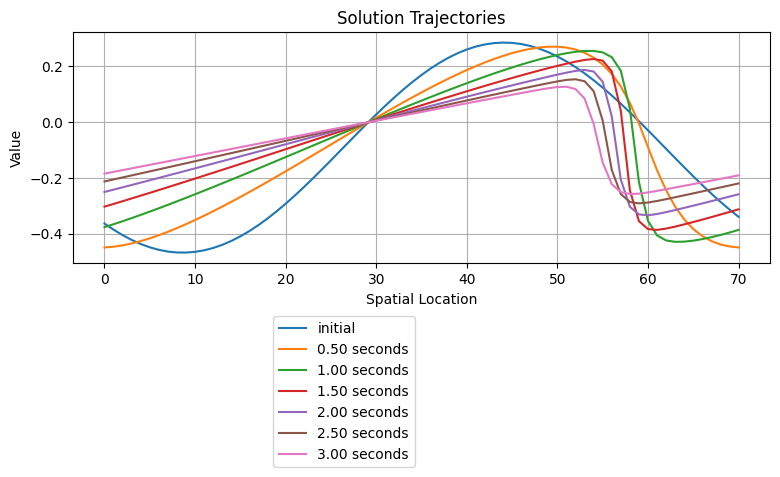

In [120]:
plot_trajectories(samples[32], t_interval=0.5)

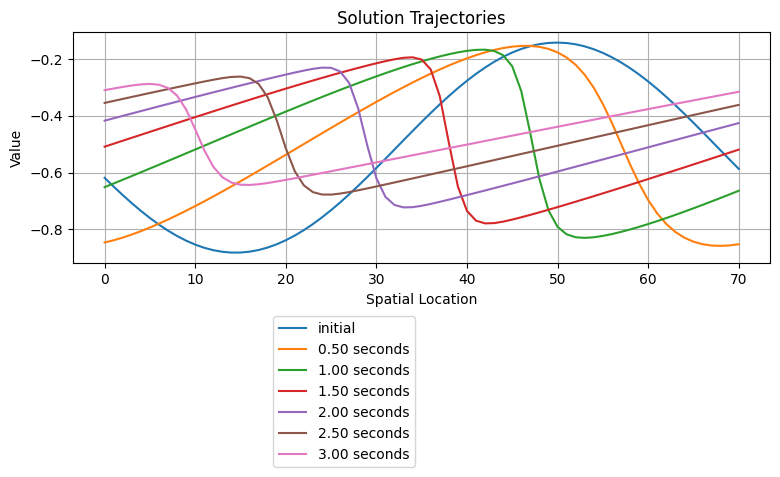

In [124]:
plot_trajectories(samples[117], t_interval=0.5)

In [114]:
samples.max(), samples.min()

(np.float64(1.121142638863817), np.float64(-1.0384988513973))

In [115]:
with open("solution_trajectories.npy", "wb") as f:
    np.save(f, samples)
with open("tmesh.npy", "wb") as f:
    np.save(f, tmesh)
with open("mesh.npy", "wb") as f:
    np.save(f, x_domain)